In [194]:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import re
from os import path
from glob import glob
from tqdm import tqdm
import numpy as np
from matplotlib import cm

In [195]:
TARGET_WINRATE = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
ROOT_PATH = '\\\\CILab_NAS_Data/homes/MMORPG/PCG/GeneratedSample'
METHODS = {
    'Random': 'random',
    'Heuristic': 'heuristic',
    'RL': 'rl',
}



In [196]:
def get_method(f_name):
    for key, val in METHODS.items():
        if f_name.find(val) != -1:
            return key
        elif f_name.find('seed') != -1:
            return 'RL'
    raise Exception(f'Unknown method! ({key})')


In [197]:
'''
dfs = []

print(path.join(ROOT_PATH, 'SkillLog_*.csv'))
files = glob(path.join(ROOT_PATH, 'skillsampling_*', 'SkillLog_*.csv'))


dfs = []
for file_path in tqdm(files):
    # print(file_path)
    file_name = path.basename(file_path)
    df = pd.read_csv(file_path)

    method = get_method(file_name)

    components = file_name.split('_')
    winrate_components = components[2].split('-')

    # Remove lastly added item
    max_episode = max(df['EpisodeCount'])
    if max_episode == 1: continue
    df = df[df['EpisodeCount'] < max_episode]  # Re

    df = df.groupby(['EpisodeCount', 'InstanceUUID']).last()
    df.loc[:, 'Method'] = method
    df.loc[:, 'Target_WinRate'] = float(winrate_components[1])

    dfs.append(df)

original_df = pd.concat(dfs)

original_df['Error_WinRate'] = original_df.apply(lambda x: abs(x['Result[0]'] - x['Target_WinRate']), axis=1)

original_df = original_df[original_df['StepCount'] >= 2]  # 변경 횟수가 5회 미만인것 제외
original_df.head()

### Order by method
_priority = {'RL': 1, 'Heuristic': 2, 'Random': 3}

original_df = original_df.sort_values(by=['Method'], key=lambda key: key.map(_priority))
original_df.to_csv('skillsampling_all.csv')
original_df.head()



'''

"\ndfs = []\n\nprint(path.join(ROOT_PATH, 'SkillLog_*.csv'))\nfiles = glob(path.join(ROOT_PATH, 'skillsampling_*', 'SkillLog_*.csv'))\n\n\ndfs = []\nfor file_path in tqdm(files):\n    # print(file_path)\n    file_name = path.basename(file_path)\n    df = pd.read_csv(file_path)\n\n    method = get_method(file_name)\n\n    components = file_name.split('_')\n    winrate_components = components[2].split('-')\n\n    # Remove lastly added item\n    max_episode = max(df['EpisodeCount'])\n    if max_episode == 1: continue\n    df = df[df['EpisodeCount'] < max_episode]  # Re\n\n    df = df.groupby(['EpisodeCount', 'InstanceUUID']).last()\n    df.loc[:, 'Method'] = method\n    df.loc[:, 'Target_WinRate'] = float(winrate_components[1])\n\n    dfs.append(df)\n\noriginal_df = pd.concat(dfs)\n\noriginal_df['Error_WinRate'] = original_df.apply(lambda x: abs(x['Result[0]'] - x['Target_WinRate']), axis=1)\n\noriginal_df = original_df[original_df['StepCount'] >= 2]  # 변경 횟수가 5회 미만인것 제외\noriginal_df.head

In [198]:
original_df = pd.read_csv('skillsampling_all.csv')

In [199]:
tmp = original_df.groupby(['Method', 'Target_WinRate'])['StepCount'].count()
print(tmp)
n_sample = min(tmp)
print(f"Num Sample:", n_sample)

Method     Target_WinRate
Heuristic  0.1               1856
           0.2               1875
           0.3               1897
           0.4               1921
           0.5               1949
           0.6               1987
           0.7               2029
RL         0.1               1475
           0.2               2944
           0.3               1491
           0.4               2677
           0.5               2990
           0.6               4108
           0.7               2647
Random     0.1               4539
           0.2               4540
           0.3               4540
           0.4               4528
           0.5               4564
           0.6               4553
           0.7               4893
Name: StepCount, dtype: int64
Num Sample: 1475


In [200]:
_priority = {'RL': 1, 'Heuristic': 2, 'Random': 3}
sampled_df = original_df.groupby(['Method', 'Target_WinRate']).sample(n=300, random_state=1)

<AxesSubplot:xlabel='StepCount', ylabel='Count'>

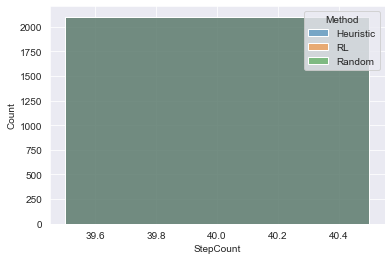

In [201]:
df = sampled_df.copy()
df.groupby(['Method']).count()

sns.histplot(data=df, x="StepCount", hue="Method")

In [202]:
print(df.describe())

       EpisodeCount  StepCount  Content[0]   Content[1]  Content[2]  \
count   6300.000000     6300.0      6300.0  6300.000000      6300.0   
mean      27.086984       40.0         0.0     4.489365         1.0   
std       23.319724        0.0         0.0     2.859861         0.0   
min        1.000000       40.0         0.0     0.000000         1.0   
25%        9.000000       40.0         0.0     2.000000         1.0   
50%       18.000000       40.0         0.0     4.000000         1.0   
75%       41.000000       40.0         0.0     7.000000         1.0   
max      100.000000       40.0         0.0     9.000000         1.0   

       Content[3]  Content[4]  Content[5]  Content[6]   Content[7]  ...  \
count      6300.0      6300.0      6300.0      6300.0  6300.000000  ...   
mean          1.0        10.0         0.0         1.0    12.016759  ...   
std           0.0         0.0         0.0         0.0     6.261594  ...   
min           1.0        10.0         0.0         1.0     1.

In [203]:
error_result = df.groupby(['Target_WinRate', 'Method'])['Method', 'Error_WinRate', 'Result[0]'].agg({'Result[0]':['mean','std'],
                                                                         'Error_WinRate':['mean','std']})
df_copy = df.copy()
df_copy['Target_WinRate'] = 'Result'
error_result_entire = df_copy.groupby(['Target_WinRate', 'Method'])['Method', 'Error_WinRate'].agg({'Error_WinRate':['mean','std']})
error_result = pd.concat([error_result, error_result_entire])
print(error_result)

                         Result[0]           Error_WinRate          
                              mean       std          mean       std
Target_WinRate Method                                               
0.1            Heuristic  0.107093  0.065299      0.043879  0.048812
               RL         0.149356  0.241742      0.155978  0.190979
               Random     0.353845  0.388900      0.335268  0.321116
0.2            Heuristic  0.205500  0.098195      0.073807  0.064861
               RL         0.266057  0.343265      0.267523  0.224502
               Random     0.366144  0.381417      0.332705  0.249222
0.3            Heuristic  0.297161  0.108164      0.079406  0.073355
               RL         0.217100  0.189356      0.168567  0.119338
               Random     0.418281  0.382290      0.348481  0.195800
0.4            Heuristic  0.415636  0.122249      0.089159  0.084937
               RL         0.376779  0.315415      0.276090  0.153451
               Random     0.381375

C:\Users\GIST\AppData\Local\Temp\ipykernel_29632\3518669268.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  error_result = df.groupby(['Target_WinRate', 'Method'])['Method', 'Error_WinRate', 'Result[0]'].agg({'Result[0]':['mean','std'],
C:\Users\GIST\AppData\Local\Temp\ipykernel_29632\3518669268.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  error_result_entire = df_copy.groupby(['Target_WinRate', 'Method'])['Method', 'Error_WinRate'].agg({'Error_WinRate':['mean','std']})


In [204]:
top = cm.get_cmap('Oranges_r', 512)
bottom = cm.get_cmap('Blues', 512)
newcolors = np.vstack((top(np.linspace(0, 1, 512)),
                       bottom(np.linspace(0, 1, 512))))
newcolors = newcolors[:, :3]

MIN = 0
MAX = 1

cmap = plt.cm.get_cmap('RdBu_r')

def rgb_to_hex(r, g, b):
    r, g, b = int(r * 255), int(g * 255), int(b * 255)
    return hex(r)[2:].zfill(2) + hex(g)[2:].zfill(2) + hex(b)[2:].zfill(2)

def styler_2(col):

    cmap = plt.cm.get_cmap('RdBu_r')
    means = col.groupby(level=0).transform('min')

    if col.name[0] != 'Result[0]':

        text_bold = ((col <= means).map({
            True: 'textbf:--rwrap;',
            False: ''
        })).to_list()
    else:
        text_bold = ['' for _ in col]

    colors = list()
    for row, bf_str in zip(col, text_bold):

        font_color = 'white' if abs(row) > 0.5 else 'black'
        # font_color = 'black'

        _val = row - 0.15
        _val = _val + 0.3
        hex_code = rgb_to_hex(*list(cmap(_val))[:3])

        tag = 'cellcolor:[HTML]{' + hex_code + '}; color:{' + font_color + '}; ' + bf_str
        colors.append(tag)
    return colors


styled_table = error_result.style.apply(styler_2).format(precision=3)

def concat_mean_std(latex_rows, start_row_num, end_row_num, column_num):

    for row_num in range(start_row_num, end_row_num):
        columns = latex_rows[row_num].split('&')
        first_column = columns[column_num]
        second_column = columns[column_num + 1]
        def _find_value(val):
            pattern = r"(\d+\.\d+)"

            match = re.search(pattern, val)

            extracted_float = match.group()
            return extracted_float

        first_val = _find_value(first_column)
        second_val = _find_value(second_column)

        if second_column.find('\\\\') != -1:
            row_break = ' \\\\'
        else:
            row_break = ''

        first_column = first_column.replace(first_val, '{' + first_val + '} ($\pm{}$' + second_val + ')')

        output = "\multicolumn{2}{c}{%s} %s" % (first_column, row_break)


        columns[column_num] = output
        del columns[column_num + 1]

        latex_rows[row_num] = '&'.join(columns)
    return latex_rows

with open('skill_controllable_table_2.tex', 'w') as f:
    latex_str = styled_table.to_latex(position_float='centering',
                                      multicol_align="c",
                                      label='tab:pcg_controllbility_small',
                                      caption='Descriptive statistics on the controllability of the generative models',
                                      hrules=True)
    latex_str = latex_str.replace('Target_WinRate', '\\begin{tabular}[x]{@{}c@{}}Target\\\\($W_{t}$)\end{tabular}')
    latex_str = latex_str.replace('Error_WinRate', 'RMSE ($\|W_{t}-W_{c}\|$)')
    latex_str = latex_str.replace('{mean} & {std}', '\multicolumn{2}{c}{Mean ($\pm{}$SD)}')
    latex_str = latex_str.replace('Result[0]', 'Generated ($W_{c}$)')
    latex_str = latex_str.replace('llrrrr', 'cl|cc|cc')
    latex_str = latex_str.replace('\\begin{table}', '\\begin{table}[!h]')

    latex_list = latex_str.splitlines()
    # print(latex_list)
    # columns = latex_list[33].split('&')
    # first_column = columns[4]
    # second_column = columns[4 + 1]
    # print("first_column:", first_column)
    # print("second_column:", second_column)
    # print("28@@@@@@@@@@@@@@@: ", latex_list[28])
    # print("29@@@@@@@@@@@@@@@: ", latex_list[29])
    # print("30@@@@@@@@@@@@@@@: ", latex_list[30])
    # print("31@@@@@@@@@@@@@@@: ", latex_list[31])
    # print("32@@@@@@@@@@@@@@@: ", latex_list[32])
    # print("33@@@@@@@@@@@@@@@: ", latex_list[33])
    # print("34@@@@@@@@@@@@@@@: ", latex_list[34])
    latex_list = concat_mean_std(latex_list, start_row_num=10, end_row_num=31, column_num=2)
    latex_list = concat_mean_std(latex_list, start_row_num=10, end_row_num=31, column_num=3)
    latex_list = concat_mean_std(latex_list, start_row_num=31, end_row_num=34, column_num=4)
    # print(latex_list)
    # print(latex_list[10])
    # print(latex_list[31])
    i = 13
    while i < len(latex_list) - 4:
        latex_list.insert(i, '\midrule')
        i += 4

    latex_str = '\n'.join(latex_list)
    f.write(latex_str)


In [229]:
diversity_df = original_df[(original_df['StepCount'] >= 2) & (original_df['Error_WinRate'] < 0.1)]  # 변경 횟수가 5회 미만인것 제외
print(diversity_df.groupby(['Method', 'Target_WinRate']).count())
diversity_df = diversity_df.groupby(['Method', 'Target_WinRate']).sample(n=300, random_state=1)

print(diversity_df.groupby(['Method', 'Target_WinRate'])['StepCount'].count())
n_sample = min(diversity_df.groupby(['Method', 'Target_WinRate'])['StepCount'].count())
diversity_df = diversity_df.groupby(['Method', 'Target_WinRate']).sample(n=n_sample, random_state=1)
print(diversity_df.groupby(['Method', 'Target_WinRate'])['StepCount'].count())


'''
_lastGeneratedSkill[7] += rangeTick * act[0];
_lastGeneratedSkill[8] += coolTick * act[1];
_lastGeneratedSkill[9] += castTimeTick * act[2];
_lastGeneratedSkill[15] += valueTick * act[3];
'''


diversity_df = diversity_df[["StepCount", "Method", "Target_WinRate",
                       "Content[7]", "Content[8]", "Content[9]", "Content[15]"]]
diversity_df.rename(columns = {"Content[7]": "Range", "Content[8]": "Cool Time", "Content[9]": "Cast Time", "Content[15]": "Damage"}, inplace = True)
origin_diversity_df = diversity_df.copy()


# tsne_np = TSNE(n_components=1).fit_transform(diversity_df[["Range", "Cool Time", "Cast Time", "Damage"]])

diversity_df = diversity_df[["Range", "Cool Time", "Cast Time", "Damage"]]
diversity_df = (diversity_df-diversity_df.min())/(diversity_df.max()-diversity_df.min())

pca_np = PCA(n_components=1).fit_transform(diversity_df)


# diversity_df['t-SNE'] = tsne_np.flatten()
diversity_df['PCA'] = pca_np.flatten()
diversity_df['Target_WinRate'] = origin_diversity_df['Target_WinRate']
diversity_df['Method'] = origin_diversity_df['Method']
diversity_df = diversity_df.reset_index()


top = cm.get_cmap('Oranges_r', 512)
bottom = cm.get_cmap('Blues', 512)
newcolors = np.vstack((top(np.linspace(0, 1, 512)),
                       bottom(np.linspace(0, 1, 512))))
newcolors = newcolors[:, :3]

MIN = 0
MAX = 1



cmap = plt.cm.get_cmap('RdBu_r')

def rgb_to_hex(r, g, b):

    r, g, b = int(r * 255), int(g * 255), int(b * 255)
    return hex(r)[2:].zfill(2) + hex(g)[2:].zfill(2) + hex(b)[2:].zfill(2)


color_map = {
    'Range': plt.cm.get_cmap('Blues'),
    'Cool Time': plt.cm.get_cmap('Oranges'),
    'Cast Time': plt.cm.get_cmap('Greens'),
    'Damage': plt.cm.get_cmap('Reds'),
    'PCA': plt.cm.get_cmap('Greys'),
}


def styler_3(col):

    means = col.groupby(level=0).transform('max')
    cmap = color_map[col.name[0]]

    min_val, max_val = min(col), max(col)

    def _minmax_scaler(val):
        return (val - min_val) / (max_val - min_val)

    text_bold = ((col == means).map({
        True: 'textbf:--rwrap;',
        False: ''
    })).to_list()

    colors = list()
    for row, bf_str in zip(col, text_bold):
        scaled = _minmax_scaler(row) * 0.4
        hex_code = rgb_to_hex(*list(cmap(scaled))[:3])
        font_color = 'white' if abs(scaled) > 0.4 else 'black'
        tag = 'cellcolor:[HTML]{' + hex_code + '}; color:{' + font_color + '}; ' + bf_str
        colors.append(tag)

    return colors

result = diversity_df.groupby(['Target_WinRate', 'Method'])['Method', 'Range', 'Cool Time', 'Cast Time', 'Damage', 'PCA'].agg(
    {'Range':['std'], 'Cool Time':['std'], 'Cast Time':['std'], 'Damage':['std'], 'PCA':['std']})

result_tmp = result.copy()
result_tmp.columns = [col[0] for col in result_tmp.columns.values]
result_tmp = result_tmp.reset_index()
result_tmp['Target_WinRate'] = 'Result'
result_tmp = result_tmp.groupby(['Target_WinRate', 'Method'])['Method', 'Range', 'Cool Time', 'Cast Time', 'Damage', 'PCA'].agg(
    {'Range':['mean'], 'Cool Time':['mean'], 'Cast Time':['mean'], 'Damage':['mean'], 'PCA':['mean']})
result_tmp.columns.set_levels(['std'], level=1, inplace=True)
print(result)
print(result_tmp)
result = pd.concat([result, result_tmp])
styled_table = result.style.apply(styler_3).format(precision=3)

with open('skill_diversity_small_2.tex', 'w') as f:
    latex_str = styled_table.to_latex(position_float='centering',
                                      multicol_align="c",
                                      label='tab:pcg_diversity_small',
                                      caption='Descriptive statistics on the diversity of the generated contents',
                                      hrules=True)
    latex_str = latex_str.replace('Target_WinRate', '\\begin{tabular}[x]{@{}c@{}}Target\\\\($W_{t}$)\end{tabular}')
    latex_str = latex_str.replace('llrrrrr', 'cl|cccc|c')

    latex_str = latex_str.replace('Cool Time', '\\begin{tabular}[x]{@{}c@{}}Cool\\\\Time\end{tabular}')
    latex_str = latex_str.replace('Cast Time', '\\begin{tabular}[x]{@{}c@{}}Cast\\\\Time\end{tabular}')
    latex_str = latex_str.replace('{std}', '{($\pm$SD)}')
    latex_str = latex_str.replace('\\begin{table}', '\\begin{table}[!h]')
    latex_list = latex_str.splitlines()

    i = 13
    while i < len(latex_list) - 4:
        latex_list.insert(i, '\midrule')
        i += 4


    latex_str = '\n'.join(latex_list)
    f.write(latex_str)

# result

                          EpisodeCount  InstanceUUID  StepCount  Time  \
Method    Target_WinRate                                                
Heuristic 0.1                     1654          1654       1654  1654   
          0.2                     1397          1397       1397  1397   
          0.3                     1285          1285       1285  1285   
          0.4                     1244          1244       1244  1244   
          0.5                     1212          1212       1212  1212   
          0.6                     1271          1271       1271  1271   
          0.7                     1419          1419       1419  1419   
RL        0.1                      534           534        534   534   
          0.2                      497           497        497   497   
          0.3                      497           497        497   497   
          0.4                      413           413        413   413   
          0.5                      486           48

C:\Users\GIST\AppData\Local\Temp\ipykernel_29632\2136218486.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  result = diversity_df.groupby(['Target_WinRate', 'Method'])['Method', 'Range', 'Cool Time', 'Cast Time', 'Damage', 'PCA'].agg(
C:\Users\GIST\AppData\Local\Temp\ipykernel_29632\2136218486.py:100: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  result_tmp = result_tmp.groupby(['Target_WinRate', 'Method'])['Method', 'Range', 'Cool Time', 'Cast Time', 'Damage', 'PCA'].agg(
C:\Users\GIST\AppData\Local\Temp\ipykernel_29632\2136218486.py:102: FutureWarning: inplace is deprecated and will be removed in a future version.
  result_tmp.columns.set_levels(['std'], level=1, inplace=True)


yield_rate_df = df.copy()
yield_rate_df['YieldRate'] = yield_rate_df['Error_WinRate'] < 0.1

yield_rate_df = yield_rate_df.groupby(['Target_WinRate', 'Method'])['StepCount', 'Method', 'Error_WinRate', 'Result[0]', 'YieldRate'].agg({
                                                                         # 'Result[0]':['mean','std'],
                                                                         # 'Error_WinRate':['mean','std'],
                                                                         'StepCount': ['mean','std'],
                                                                         'YieldRate': ['mean','std']})

yield_rate_df

print(yield_rate_df)

top = cm.get_cmap('Oranges_r', 512)
bottom = cm.get_cmap('Blues', 512)
newcolors = np.vstack((top(np.linspace(0, 1, 512)),
                       bottom(np.linspace(0, 1, 512))))
newcolors = newcolors[:, :3]

MIN = 0
MAX = 1



cmap = plt.cm.get_cmap('RdBu_r')

def rgb_to_hex(r, g, b):

    r, g, b = int(r * 255), int(g * 255), int(b * 255)
    return hex(r)[2:].zfill(2) + hex(g)[2:].zfill(2) + hex(b)[2:].zfill(2)

def styler_3(col):

    if col.name[0] == 'StepCount':
        means = col.groupby(level=0).transform('min')
    elif col.name[0] == 'YieldRate':
        means = col.groupby(level=0).transform('max')
    else:
        raise Exception()
    min_val, max_val = min(col), max(col)

    def _minmax_scaler(val):
        return (val - min_val) / (max_val - min_val)

    text_bold = ((col == means).map({
        True: 'textbf:--rwrap;',
        False: ''
    })).to_list()

    colors = list()
    for row, bf_str in zip(col, text_bold):
        scaled = _minmax_scaler(row) * 0.4
        hex_code = rgb_to_hex(*list(cmap(scaled))[:3])
        font_color = 'white' if abs(scaled) > 0.4 else 'black'
        tag = 'cellcolor:[HTML]{' + 'ffffff' + '}; color:{' + font_color + '}; ' + bf_str
        colors.append(tag)

    return colors


styled_table = yield_rate_df.style.apply(styler_3).format(precision=3)

with open('yield_rate.tex', 'w') as f:
    latex_str = styled_table.to_latex(position_float='centering',
                                      multicol_align="c",
                                      label="tab:yield_rate",
                                      caption="Descriptive statistics on the step count and yield rate",
                                      hrules=True)
    latex_str = latex_str.replace('Target_WinRate', '\\begin{tabular}[x]{@{}c@{}}Target\\\\($W_{t}$)\end{tabular}')
    latex_str = latex_str.replace('llrrrrr', 'cl|cccc|c')

    latex_str = latex_str.replace('StepCount', 'Action Count')
    latex_str = latex_str.replace('YieldRate', 'Yield Rate')


    latex_str = latex_str.replace('{mean} & {std}', '\multicolumn{2}{c}{Mean ($\pm{}$SD)}')
    latex_str = latex_str.replace('\\begin{table}', '\\begin{table}[!h]')

    latex_list = latex_str.splitlines()

    latex_list = concat_mean_std(latex_list, start_row_num=10, end_row_num=31, column_num=2)
    latex_list = concat_mean_std(latex_list, start_row_num=10, end_row_num=31, column_num=3)

    i = 13
    while i < len(latex_list) - 4:
        latex_list.insert(i, '\midrule')
        i += 4


    latex_str = '\n'.join(latex_list)
    f.write(latex_str)

result